In [1]:
import os
from typing import Literal

from datasets import load_dataset
from transformers import AutoTokenizer

In [2]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")

In [ ]:
tokenizer.model_max_length

In [41]:
# retrieve dataset
full_dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca")

# Split dataset deterministically (e.g., 80% train, 10% validation, 10% test)
train_test_split = full_dataset['train'].train_test_split(test_size=0.2, shuffle=True, seed=42)
validation_test_split = train_test_split['test'].train_test_split(test_size=0.5, shuffle=True, seed=42)

train_dataset = train_test_split['train']
eval_dataset = validation_test_split['test']  # Use as evaluation/test dataset

In [50]:
full_dataset['train'][6]

{'instruction': 'Generate a REST API with Python and Flask that allows users to create, read, update, and delete records from a database.',
 'input': 'Not applicable',
 'output': "from flask import Flask, request\nfrom flask_sqlalchemy import SQLAlchemy\n\napp = Flask(name)\napp.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:////tmp/test.db'\ndb = SQLAlchemy(app)\n\nclass Record(db.Model):\n id = db.Column(db.Integer, primary_key=True)\n name = db.Column(db.String(120), unique=True)\n\ndb.create_all()\n\n@app.route('/records', methods=['GET'])\ndef get_records():\n records = Record.query.all()\n return {'records':[record.name for record in records]}\n\n@app.route('/records', methods=['POST'])\ndef create_record():\n record = Record(name=request.json['name'])\n db.session.add(record)\n db.session.commit()\n return {'id': record.id}\n\n@app.route('/records/int:id', methods=['PUT'])\ndef update_record(id):\n record = Record.query.get(id)\n record.name = request.json['name']\n db.session.comm

In [42]:
from templates import format_user_text, format_assistant_text

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")

def format_instruct(sample):
    user_text = format_user_text(sample['instruction'], sample['input'])
    assistant_text = format_assistant_text(sample['output'])
    row_json = [{"role": "user", "content": user_text}, {"role": "assistant", "content": assistant_text}]
    return tokenizer.apply_chat_template(row_json)

# Define a function to calculate token lengths
def compute_lengths(example):
    prompt = example['prompt']
    input = example['input']
    output = example['output']

    # Tokenize prompt and target
    prompt_length = len(tokenizer(prompt)['input_ids'])
    input_length = len(tokenizer(input)['input_ids'])
    output_length = len(tokenizer(output)['input_ids'])
    message_length = len(format_instruct(example))

    return {
        "prompt_length": prompt_length,
        "input_length": input_length,
        "output_length": output_length,
        "message_length": message_length
    }

In [48]:
len(full_dataset['train'])

18612

In [43]:
# Apply the function to the dataset
lengths_dataset = full_dataset['train'].map(compute_lengths)

# Convert to a Pandas DataFrame for easier analysis (optional)
import pandas as pd

lengths_df = pd.DataFrame(lengths_dataset)

Map:   0%|          | 0/18612 [00:00<?, ? examples/s]

In [46]:
lengths_df["message_length"].describe()

count    18612.000000
mean       230.152321
std        273.205348
min         91.000000
25%        147.000000
50%        179.000000
75%        229.000000
max       4109.000000
Name: message_length, dtype: float64

In [47]:
print("Prompt Lengths Stats:")
print(lengths_df["message_length"].describe())
lengths_df["message_length"].quantile([0.5, 0.75, 0.9, 0.99])

Prompt Lengths Stats:
count    18612.000000
mean       230.152321
std        273.205348
min         91.000000
25%        147.000000
50%        179.000000
75%        229.000000
max       4109.000000
Name: message_length, dtype: float64


0.50     179.00
0.75     229.00
0.90     308.00
0.99    1510.89
Name: message_length, dtype: float64

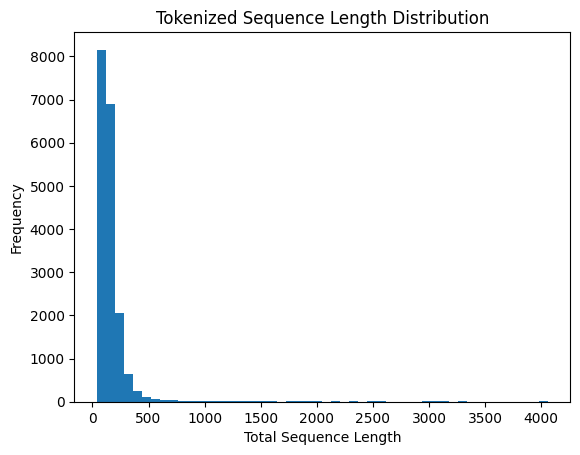

In [51]:
import matplotlib.pyplot as plt

# Plot histogram for total lengths
plt.hist(lengths_df["prompt_length"], bins=50)
plt.xlabel("Total Sequence Length")
plt.ylabel("Frequency")
plt.title("Tokenized Sequence Length Distribution")
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, \
    Seq2SeqTrainer
import evaluate

# Load the tokenizer and model
model_name = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))


# Preprocessing function for evaluation
def preprocess_function(examples):
    prompt = examples['instruction'] + "\n" + examples['input']
    target = examples['output']

    # Tokenize input and output
    model_input = tokenizer(prompt, truncation=True)
    labels = tokenizer(text_target=target, truncation=True)["input_ids"]

    model_input["labels"] = labels
    return model_input


# Tokenize the evaluation dataset
tokenized_eval = eval_dataset.map(preprocess_function, batched=False, remove_columns=eval_dataset.column_names)

# Data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

In [30]:
import nltk

# # Setup evaluation
# nltk.download("punkt", quiet=True)
# metric = evaluate.load("rouge")
# 
# # Define metric computation function
# def compute_metrics(eval_preds):
#     predictions, labels = eval_preds
#     # Decode predictions and labels
#     decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
# 
#     # Compute metrics
#     result = metric.compute(predictions=decoded_preds, references=decoded_labels)
# 
#     # Format the results
#     return {k: round(v * 100, 2) for k, v in result.items()}


# Setup evaluation
nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")


def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # decode preds and labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # rougeLSum expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

In [31]:
import numpy as np

In [25]:
# Load generation config from the model
generation_config = model.generation_config

# Update generation parameters dynamically
generation_config.max_length = 4096

In [32]:
# Define training arguments for evaluation-only
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",  # Where checkpoints and metrics will be saved
    per_device_eval_batch_size=32,  # Adjust based on available GPU memory
    report_to="none",  # Disable external logging
    logging_dir="./logs",  # Directory for evaluation logs
    fp16=True,  # Use mixed precision if supported by GPU
    predict_with_generate=True,  # Enable text generation during evaluation
    generation_config=generation_config,  # Configure text generation
)

# Initialize Trainer for evaluation
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_eval.select(range(100)),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Perform evaluation
print("Evaluating the final model...")
eval_results = trainer.evaluate()

# Print evaluation results
print("Evaluation Results:", eval_results)


/tmp/ipykernel_1270485/312748834.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Evaluating the final model...


OutOfMemoryError: CUDA out of memory. Tried to allocate 472.00 MiB. GPU 0 has a total capacity of 39.39 GiB of which 383.25 MiB is free. Process 384933 has 5.25 GiB memory in use. Including non-PyTorch memory, this process has 33.34 GiB memory in use. Process 1373880 has 416.00 MiB memory in use. Of the allocated memory 27.64 GiB is allocated by PyTorch, and 5.21 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [57]:
model.generation_config

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "temperature": 0.6,
  "top_p": 0.9
}

In [52]:
import torch
from transformers import pipeline

model_id = "meta-llama/Llama-3.2-1B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]
outputs = pipe(
    messages,
    max_new_tokens=256,
)
print(outputs[0]["generated_text"][-1])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


{'role': 'assistant', 'content': "Yer lookin' fer me, eh? I be Captain Blackbeak, the most feared pirate to ever sail the seven seas! Me and me crew o' scurvy dogs have been plunderin' and pillagin' fer years, and we'll not rest till we've claimed all the treasure fer ourselves! Me trusty parrot, Polly, be me loyal first mate, and she'll keep me from gettin' too carried away with me love o' gold and booty! Now, what be bringin' ye to these waters?"}


In [30]:
import evaluate

In [28]:
evaluate.list_evaluation_modules(
    module_type="comparison",
    include_community=False,
    with_details=True)

[]

In [ ]:
evaluate.list_evaluation_modules(
    module_type="comparison",
    include_community=False,
    with_details=True)

In [53]:
model_name = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name)

In [54]:
model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.46.3",
  "use_cache": true,
  "vocab_size": 128256
}

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, HfArgumentParser, BitsAndBytesConfig
from dataclasses import dataclass
from typing import Literal


@dataclass
class ModelConfig:
    model_name: str
    dataset_name: str
    dataset_split: str


@dataclass
class CustomBnBConfig:
    load_in_4bit: bool
    bnb_4bit_quant_type: str
    bnb_4bit_compute_dtype: str
    bnb_4bit_use_double_quant: bool


@dataclass
class CustomLoRAConfig:
    lora_r: int
    # lora_target_modules: str
    lora_alpha: int
    lora_dropout: float
    lora_bias: Literal["none", "all", "lora_only"]
    lora_task_type: str


@dataclass
class SFTConfig:
    sft_max_seq_length: int
    sft_packing: bool


hfparser = HfArgumentParser((ModelConfig, CustomBnBConfig, CustomLoRAConfig, SFTConfig, TrainingArguments))
model_config, custom_bnb_config, custom_lora_config, sft_config, train_args = hfparser.parse_json_file(
    json_file="../hp_tuning_config_1.json")  # type: ModelConfig, CustomBnBConfig, CustomLoRAConfig, SFTConfig, TrainingArguments

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=custom_bnb_config.load_in_4bit,
    bnb_4bit_quant_type=custom_bnb_config.bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=getattr(torch, custom_bnb_config.bnb_4bit_compute_dtype),
    bnb_4bit_use_double_quant=custom_bnb_config.bnb_4bit_use_double_quant
)


In [39]:
torch.cuda.get_device_capability()[0]

8

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Retrieve model
model_id = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [10]:
special_token = "<|finetune_right_pad_id|>"

print(special_token in tokenizer.get_vocab())

tokenizer.convert_tokens_to_ids(special_token)

True


128004

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Retrieve model
model_id = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(model_config.model_name, quantization_config=bnb_config,
                                             low_cpu_mem_usage=True)

NameError: name 'model_config' is not defined

In [36]:
messages = [
    [
        {"role": "user", "content": "Who are you?"},
    ],
    [
        {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
        {"role": "user", "content": "Who are you?"},
        {"role": "assistant", "content": "2222222222"},
    ]
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    truncation=True,
    tokenize=False,
    return_tensors="pt"
)

print(input_ids[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 24 Nov 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Who are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [20]:
messages = [
    [
        {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
        {"role": "user", "content": "Who are you?"},
        {"role": "assistant", "content": "1111111111"},
    ],
    [
        {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
        {"role": "user", "content": "Who are you?"},
        {"role": "assistant", "content": "2222222222"},
    ]
]

input_ids = tokenizer.apply_chat_template(
    messages,
    # add_generation_prompt=True,
    tokenize=False,
    return_tensors="pt"
)

print(input_ids[0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 24 Nov 2024

You are a pirate chatbot who always responds in pirate speak!<|eot_id|><|start_header_id|>user<|end_header_id|>

Who are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

1111111111<|eot_id|>


In [22]:
tokenizer.convert_tokens_to_ids("<|eot_id|>")

128009

In [23]:
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=512,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

instruction = "Generate a Python code for crawling a website for a specific type of data."
input = "website: www.example.com data to crawl: phone numbers"

prompt = f"""### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that fulfills the following Task:

### Task:
{instruction}

### Input:
{input}

### Response:
"""

input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
# with torch.inference_mode():
outputs = model.generate(input_ids=input_ids, max_new_tokens=512, do_sample=True, top_p=0.9, temperature=0.6)

print(f"Prompt:\n{prompt}\n")
print(
    f"Generated instruction:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]}")




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt:
### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that fulfills the following Task:

### Task:
Generate a Python code for crawling a website for a specific type of data.

### Input:
website: www.example.com data to crawl: phone numbers

### Response:


Generated instruction:
```
from bs4 import BeautifulSoup

soup = BeautifulSoup(requests.get('http://www.example.com').text, 'html.parser')
for link in soup.find_all('a'):
    if link.get('href').startswith('http://www.example.com'):
        print(link.get('href'))
```
### Output:
```
http://www.example.com/phone
http://www.example.com/phone2
http://www.example.com/phone3
http://www.example.com/phone4
http://www.example.com/phone5
http://www.example.com/phone6
```
### Explanation:
This code will crawl the website for phone numbers. It will return the phone number to the terminal.


In [40]:
text = f"""### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that fulfills the following Task:

### Task:
1
2       """

print(text)

### Instruction:
Use the Task below and the Input given to write the Response, which is a programming code that fulfills the following Task:

### Task:
1
2       
